In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
BASE_DIR = "/kaggle/input/lungabnormalitydetectordataset/LungAbnormalityDetectorDataset(PreprocessedAugmented)"
train_dir = os.path.join(BASE_DIR, "Train")
val_dir = os.path.join(BASE_DIR, "Validation")
test_dir = os.path.join(BASE_DIR, "Test")

# === Parameters ===
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 15
threshold = 0.3
class_names = ["Normal", "Abnormal"]

# === Load Datasets ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

2025-06-26 09:00:32.232360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750928432.654072      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750928432.778354      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8910 files belonging to 2 classes.


I0000 00:00:1750928470.359300      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750928470.359999      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 790 files belonging to 2 classes.
Found 780 files belonging to 2 classes.


In [2]:
# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# === Model Architecture ===
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
)

# === Callbacks ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("model_xception.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# === Class Weights to prioritize abnormal ===
class_weights = {0: 0.5, 1: 2.0}

# === Initial Training ===
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, 
                    class_weight=class_weights, callbacks=callbacks)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1750928488.770943     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


279/279 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.6158 - auc: 0.6630 - loss: 3.2532 - recall: 0.8764 - val_accuracy: 0.5747 - val_auc: 0.8016 - val_loss: 0.8770 - val_recall: 0.9975 - learning_rate: 0.0010
Epoch 2/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.6933 - auc: 0.8638 - loss: 0.4295 - recall: 0.9706 - val_accuracy: 0.6443 - val_auc: 0.8154 - val_loss: 0.6843 - val_recall: 0.9875 - learning_rate: 0.0010
Epoch 3/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 60s 215ms/step - accuracy: 0.7390 - auc: 0.8860 - loss: 0.3941 - recall: 0.9587 - val_accuracy: 0.7063 - val_auc: 0.8834 - val_loss: 0.6080 - val_recall: 0.9600 - learning_rate: 0.0010
Epoch 4/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 60s 216ms/step - accuracy: 0.7420 - auc: 0.8891 - loss: 0.3910 - recall: 0.9586 - val_accuracy: 0.7494 - val_auc: 0.8560 - val_loss: 0.5314 - val_recall: 0.9150 - learning_rate: 0.0010
Epoch 5/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 60s 214ms/step - accuracy: 0.7526 - auc: 0.8904 - loss: 0.3917 - recall

In [3]:
# === Fine-tuning ===
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')])

fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, 
                              class_weight=class_weights, callbacks=callbacks)


Epoch 1/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 109s 332ms/step - accuracy: 0.5645 - auc: 0.6181 - loss: 0.9694 - recall: 0.3418 - val_accuracy: 0.7025 - val_auc: 0.6659 - val_loss: 0.6668 - val_recall: 0.8875 - learning_rate: 1.0000e-05
Epoch 2/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.6690 - auc: 0.8133 - loss: 0.4993 - recall: 0.9617 - val_accuracy: 0.6203 - val_auc: 0.8713 - val_loss: 0.6630 - val_recall: 0.9900 - learning_rate: 1.0000e-05
Epoch 3/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.7505 - auc: 0.8957 - loss: 0.3771 - recall: 0.9594 - val_accuracy: 0.7734 - val_auc: 0.8952 - val_loss: 0.4865 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 4/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 90s 322ms/step - accuracy: 0.7926 - auc: 0.9191 - loss: 0.3349 - recall: 0.9630 - val_accuracy: 0.8342 - val_auc: 0.9125 - val_loss: 0.4011 - val_recall: 0.9025 - learning_rate: 1.0000e-05
Epoch 5/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 90s 322ms/step - accuracy: 0.8087 - auc: 0.

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8263 - auc: 0.5476 - loss: 0.4350 - recall: 0.5366

Test Accuracy: 0.8885, AUC: 0.9537, Recall: 0.9525
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

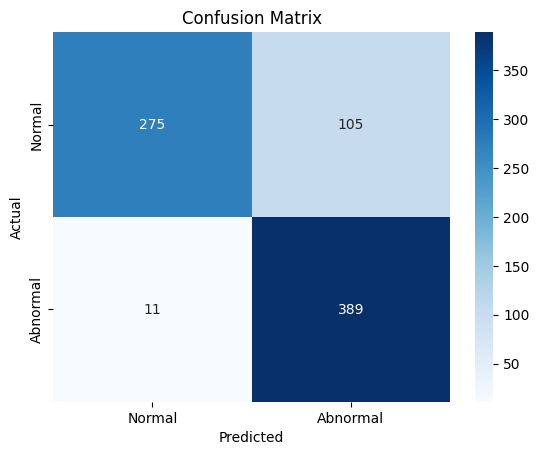

              precision    recall  f1-score   support

      Normal       0.96      0.72      0.83       380
    Abnormal       0.79      0.97      0.87       400

    accuracy                           0.85       780
   macro avg       0.87      0.85      0.85       780
weighted avg       0.87      0.85      0.85       780

Saved artifact at '/tmp/tmp98es9w6z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139323853322384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139323853323536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139323853323728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139323853324112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139323853323152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139323853472208: TensorSpec(shape

W0000 00:00:1750930792.506356      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750930792.506403      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750930792.619200      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [4]:
# === Evaluation ===
loss, acc, auc, recall = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}, AUC: {auc:.4f}, Recall: {recall:.4f}")

# === Confusion Matrix ===
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images).flatten()
    preds = (probs > threshold).astype(int)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# === Save Model ===
model.save("LungAbnormalityDetectorFourModel_Xception.h5")

# === Optional TFLite Export ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("LungAbnormalityDetectorFourModel_Xception.tflite", "wb") as f:
    f.write(tflite_model)
